## Costa Rican Household Poverty Level Prediction

> Competition Link: https://www.kaggle.com/c/costa-rican-household-poverty-prediction

> All credits go to the amazing notebook by Will Koehrsen: https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

> Will Koehrsen Kaggle profile: https://www.kaggle.com/willkoehrsen  | Medium: http://medium.com/@williamkoehrsen/

---


Welcome to another Kaggle challenge! The objective of the Costa Rican Household Poverty Level Prediction contest is to develop a machine learning model that can predict the poverty level of households using both individual and household characteristics. This "data science for good" project offers the opportunity to put our skills towards a task more beneficial to society than getting people to click on ads!

In this notebook, we will walk through a complete machine learning solution: first, get introduced to the problem, then perform a thorough Exploratory Data Analysis of the dataset, work on feature engineering, try out multiple machine learning models, select a model, work to optimize the model, and finally, inspect the outputs of the model and draw conclusions. __While this notebook may not get us to the top of the leaderboard, it is meant to be used as a teaching tool to give you a solid foundation to build on for future machine learning projects. Kaggle projects can teach us a lot about machine learning, but several of the strategies used to get to the very top of the leaderboard are not best practices, so here we'll stick to building a very good - although not quite first place - machine learning solution. While Kaggle projects are competitions, I think they are best described as "a machine learning education" disguised as a contest!__"

### Problem and Data Explanation


The data for this competition is provided in two files: `train.csv` and `test.csv`. 

he training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents __one individual__ and each column is a __feature, either unique to the individual, or for the household of the individual__. 

The training set has one additional column, `Target`, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty. 

This is a __supervised multi-class classification machine learning problem__

### Objective

The objective is to predict poverty on a __household level__. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some _aggregations of the individual data_ for each household. Moreover, we have to make a prediction for every individual in the test set, but _"ONLY the heads of household are used in scoring"_ which means we want to predict poverty on a household basis. 


__Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where `parentesco1 == 1.0`.__ We will cover how to correct this in the notebook


The `Target` values represent poverty levels as follows:

    1 = extreme poverty 
    2 = moderate poverty 
    3 = vulnerable households 
    4 = non vulnerable households
    
    
The explanations for all 143 columns can be found in the [competition documentation](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data), but a few to note are below:

* __Id__: a unique identifier for each individual, this should not be a feature that we use! 
* __idhogar__: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.
* __parentesco1__: indicates if this person is the head of the household.
* __Target__: the label, which should be equal for all members in a household

When we make a model, we'll train on a household basis with the label for each household _the poverty level of the head of household_. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with _no head of household_ which means that unfortunately we can't use this data for training. These issues with the data are completely typical of __real-world__ data and hence this problem is great preparation for the datasets you'll encounter in a data science job! 


### Some ideas based on data description

Some features have an order to them

```
epared1, =1 if walls are bad
epared2, =1 if walls are regular
epared3, =1 if walls are good
etecho1, =1 if roof are bad
etecho2, =1 if roof are regular
etecho3, =1 if roof are good
eviv1, =1 if floor are bad
eviv2, =1 if floor are regular
eviv3, =1 if floor are good
```

We can encode them numerically

---

`hogar_total = hogar_adul + hogar_nin`: check if true, if yes, its a redundant feature

---

What info do these squared vars add?

```
SQBescolari, escolari squared
SQBage, age squared
SQBhogar_total, hogar_total squared
SQBedjefe, edjefe squared
SQBhogar_nin, hogar_nin squared
SQBovercrowding, overcrowding squared
SQBdependency, dependency squared
SQBmeaned, square of the mean years of education of adults (>=18) in the household
agesq, Age squared
```

### Metric

Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the __Macro F1 Score.__ You may be familiar with the [standard F1 score](http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) for binary classification problems which is the harmonic mean of precision and recall:

$$F_1 = \frac{2}{\tfrac{1}{\mathrm{recall}} + \tfrac{1}{\mathrm{precision}}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

For mutli-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class _without taking into account label imbalances_. 

$$\text{Macro F1} = \frac{\text{F1 Class 1} + \text{F1 Class 2} + \text{F1 Class 3} + \text{F1 Class 4}}{4}$$

In other words, the number of occurrences of each label does not figure into the calculation when using macro (while it does when using the "weighted" score). (For more information on the differences, look at the [Scikit-Learn Documention for F1 Score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) or this [Stack Exchange question and answers](https://datascience.stackexchange.com/q/15989/42908). If we want to assess our performance, we can use the code:

```
from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro`)
```

__For this problem, the labels are imbalanced, which makes it a little strange to use macro averaging for the evaluation metric, but that's a decision made by the organizers and not something we can change! In your own work, you want to be aware of label imbalances and choose a metric accordingly.__

### Roadmap

The end objective is a machine learning model that can predict the poverty level of a household. However, before we get carried away with modeling, it's important to understand the problem and data. Also, we want to evaluate numerous models before choosing one as the "best" and after building a model, we want to investigate the predictions. Our roadmap is therefore as follows:


1. Understand the problem (we're almost there already)
2. Exploratory Data Analysis
3. Feature engineering to create a dataset for machine learning
4. Compare several baseline machine learning models
5. Try more complex machine learning models
6. Optimize the selected model
7. Investigate model predictions in context of problem
6. Draw conclusions and lay out next steps 

The steps laid out above are iterative meaning that while we will go through them one at a time, we might go back to an earlier step and revisit some of our decisions. In general, data science is a non-linear pracice where we are constantly evaluating our past decisions and making improvements. In particular, feature engineering, modeling, and optimization are steps that we often repeat because we never know if we got them right the first time!

We have a pretty good grasp of the problem, so we'll move into the Exploratory Data Analysis (EDA) and feature engineering. For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures). 

Once we have a good grasp of the data and any potentially useful relationships, we can do some feature engineering (the most important part of the machine learning pipeline) and establish a baseline model. This won't get us to the top of the leaderboard, but it will provide a strong foundation to build on! 

With all that info in mind (don't worry if you haven't got all the details), let's get started! 


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

print (sns.__version__)

0.9.0


### Read in Data and Look at Summary Information

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print (train.shape, test.shape)
train.head()

(9557, 143) (23856, 142)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or [ordinal variables](https://www.ma.utexas.edu/users/mks/statmistakes/ordinal.html) with discrete ordered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

Let's glance at the test data which has many more rows (individuals) than the train. It does have one fewer column because there's no Target!

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### Integer columns exploration

Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.

In [5]:
train.select_dtypes(np.int64).head()

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,agesq,Target
0,0,3,0,1,1,0,0,1,1,0,0,0,0,1,1,1,1,10,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1849,4
1,0,4,0,1,1,1,0,1,1,0,0,0,0,1,1,1,1,12,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,4489,4
2,0,8,0,1,1,0,0,0,0,0,1,1,0,1,1,1,1,11,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,8464,4
3,0,5,0,1,1,1,0,2,2,1,1,2,1,3,4,4,4,9,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0,4,0,0,0,1,0,0,0,0,0,3,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,289,4
4,0,5,0,1,1,1,0,2,2,1,1,2,1,3,4,4,4,11,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,4,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1369,4


In [6]:
train.select_dtypes(np.int64).nunique()

hacdor             2
rooms             11
hacapo             2
v14a               2
refrig             2
v18q               2
r4h1               6
r4h2               9
r4h3               9
r4m1               6
r4m2               7
r4m3               9
r4t1               7
r4t2              11
r4t3              13
tamhog            13
tamviv            14
escolari          22
hhsize            13
paredblolad        2
paredzocalo        2
paredpreb          2
pareddes           2
paredmad           2
paredzinc          2
paredfibras        2
paredother         2
pisomoscer         2
pisocemento        2
pisoother          2
                  ..
instlevel6         2
instlevel7         2
instlevel8         2
instlevel9         2
bedrooms           7
tipovivi1          2
tipovivi2          2
tipovivi3          2
tipovivi4          2
tipovivi5          2
computer           2
television         2
mobilephone        2
qmobilephone      11
lugar1             2
lugar2             2
lugar3       

`nunique()` returns the number of unique items in each column

But we want to see the distribution of the number of unique values, for e.g in how many cols are there 2 unique values and so on.. So we apply `value_counts` on this

In [7]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index()

1       1
2     101
4       2
6       2
7       3
9       3
10      3
11      3
13      5
14      1
22      3
97      3
dtype: int64

This tells us that there are 101 cols in which there are 2 unique values and so on.. Lets plot these

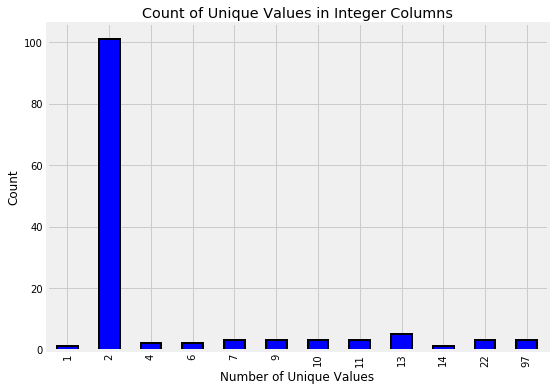

In [8]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

The columns with only 2 unique values represent Booleans (0 or 1). In a lot of cases, this boolean information is already on a household level. For example, the `refrig` column says whether or not the household has a refrigerator. When it comes time to make features from the Boolean columns that are on the household level, we will _not need to aggregate_ these. However, the Boolean columns that are on the individual level will need to be aggregated. 


#### Float Columns

Another column type is floats which represent continuous variables. We can make a quick distribution plot to show the distribution of all float columns. We'll use an [`OrderedDict`](https://pymotw.com/2/collections/ordereddict.html) to map the poverty levels to colors because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).

The following graphs shows the distributions of the `float` columns colored by the value of the `Target`. With these plots, we can see if there is a significant difference in the variable distribution depending on the household poverty level.

In [9]:
data_desc = pd.read_csv('../input/codebook.csv')

data_desc.loc[data_desc['Variable name'] == 'v2a1']['Variable name'].values[0]

'v2a1'

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


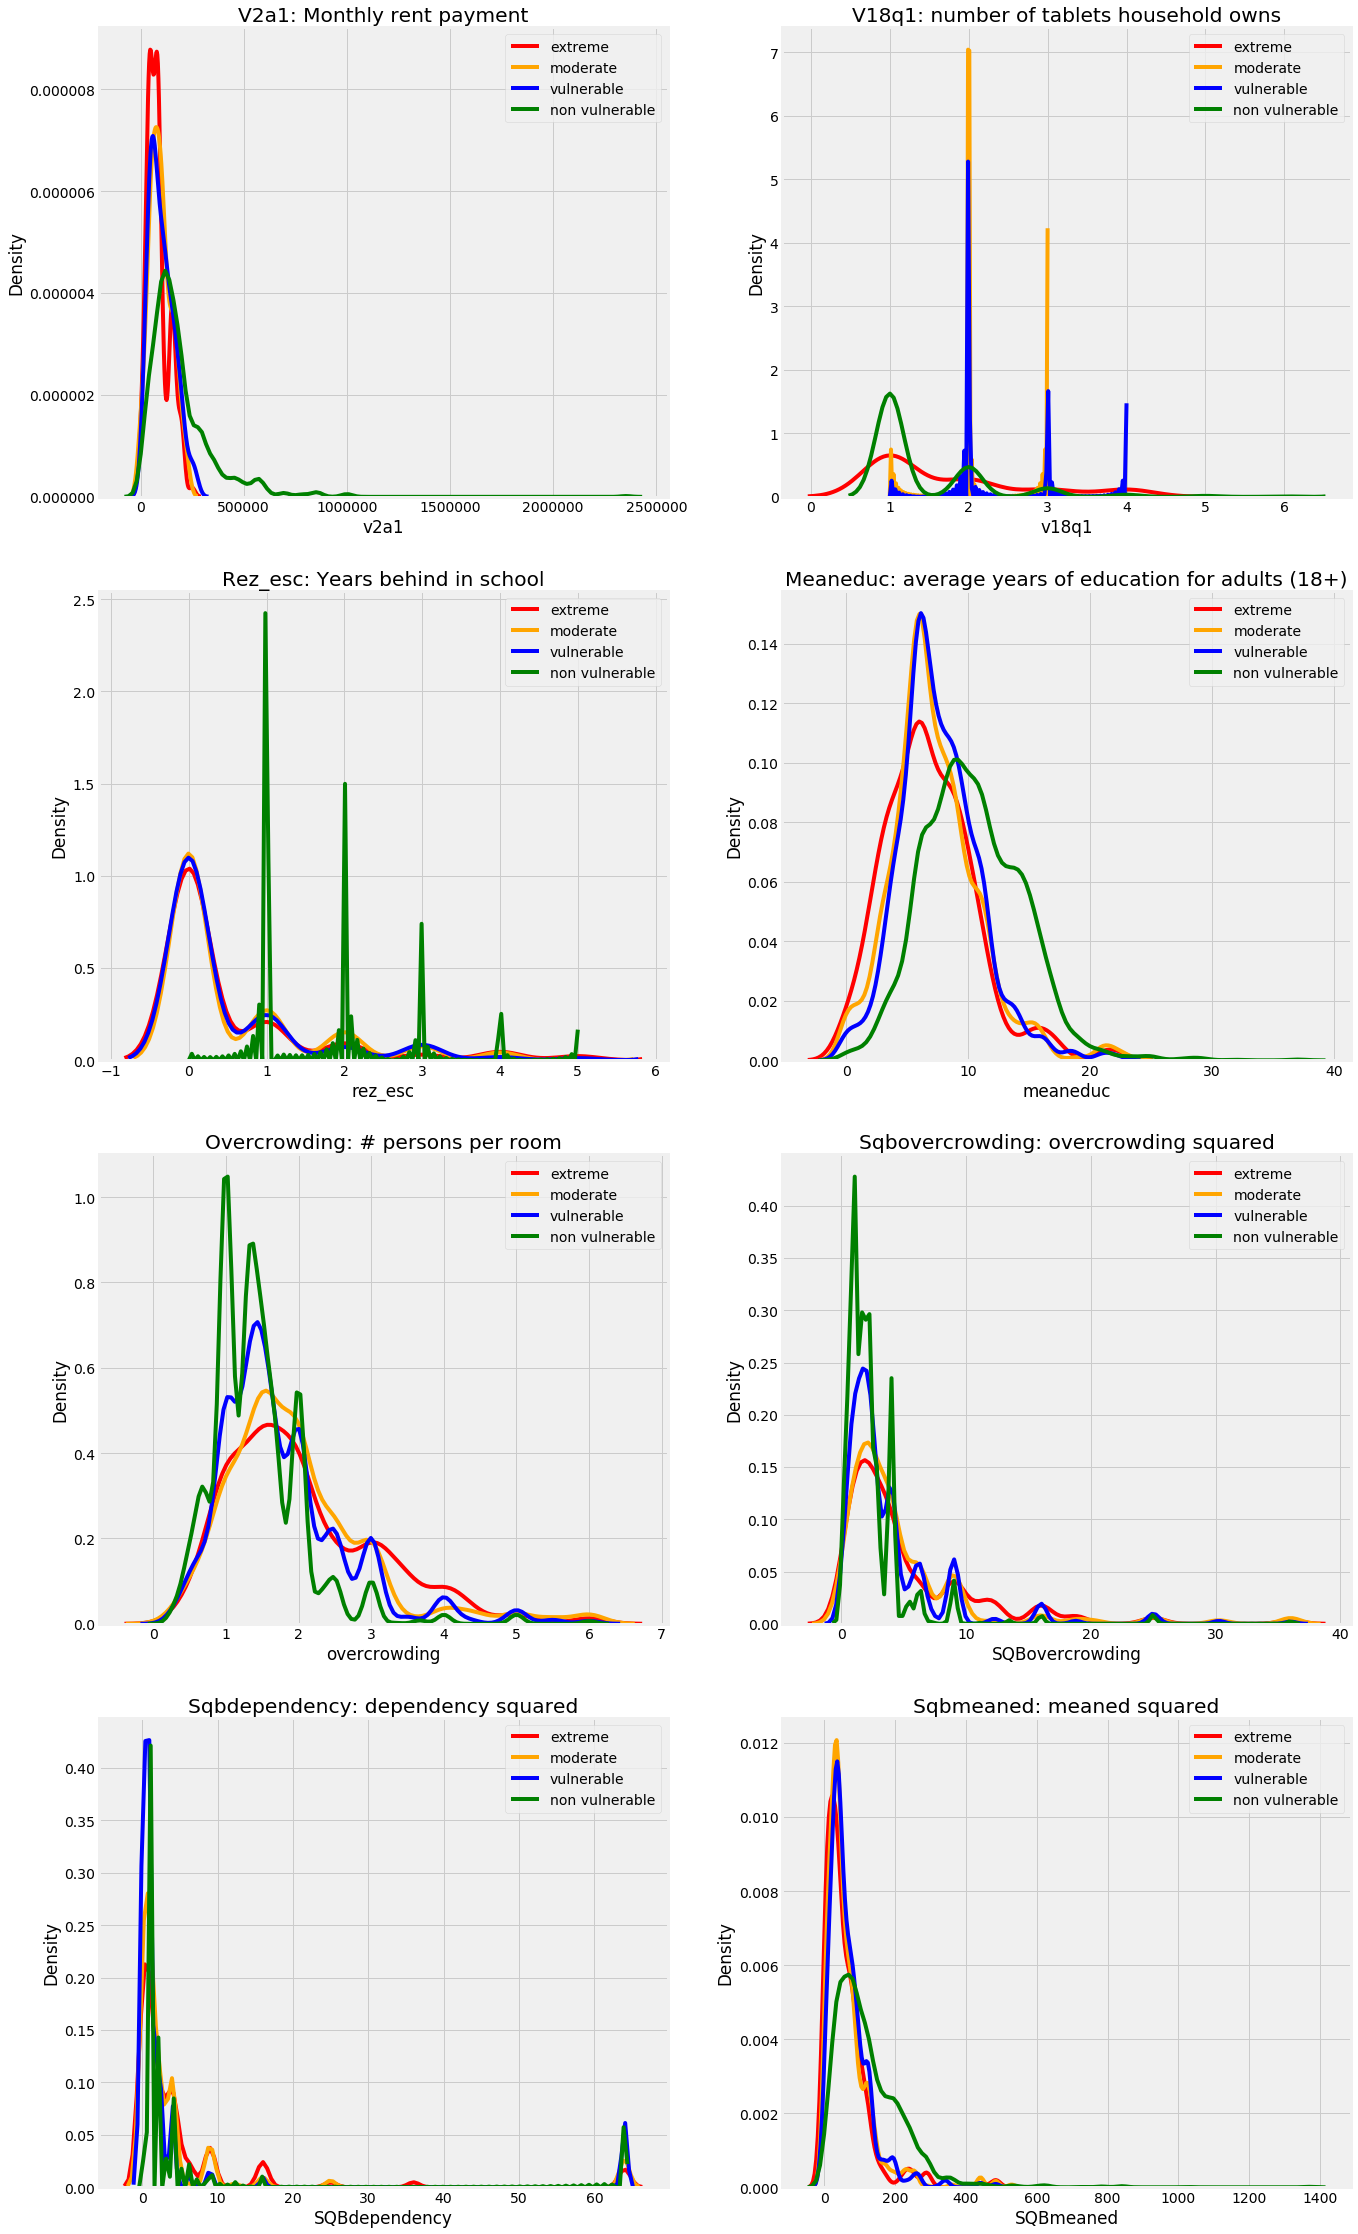

In [10]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    
    ### get the col desc
    col_desc = data_desc.loc[data_desc['Variable name'] == col]['Variable description'].values[0]
    
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna().values, 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()}: {col_desc}'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Later on we'll calculate correlations between the variables and the `Target` to gauge the relationships between the features, but these plots can already give us a sense of which variables may be most "relevant" to a model. For example, the `meaneduc`, representing the average education of the adults in the household appears to be related to the poverty level: __a higher average adult education leads to higher values of the target which are less severe levels of poverty__. The theme of the importance of education is one we will come back to again and again in this notebook! 

#### Object Columns

The last column type is `object` which we can view as follows.

In [11]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


What exactly do these columns represent?

In [12]:
data_desc.loc[data_desc['Variable name'].isin(['idhogar', 'dependency', 'edjefe', 'edjefa'])]

,Variable name,Variable description
94,idhogar,Household level identifier
99,dependency,Dependency rate
100,edjefe,years of education of male head of household
101,edjefa,years of education of female head of household


The `Id` and `idhogar` object types make sense because these are identifying variables. However, the other columns seem to be a mix of strings and numbers which we'll need to address before doing any machine learning. According to the documentation for these columns:


* `dependency`: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* `edjefe`: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* `edjefa`: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

These explanations clear up the issue. For these three variables, __"yes" = 1__ and __"no" = 0__. We can correct the variables using a mapping and convert to floats. 

Lets just confirm the unique values of these columns

In [13]:
train['edjefe'].value_counts()

no     3762
6      1845
11      751
9       486
3       307
15      285
8       257
7       234
5       222
14      208
17      202
2       194
4       137
16      134
yes     123
12      113
10      111
13      103
21       43
18       19
19       14
20        7
Name: edjefe, dtype: int64

In [14]:
train['edjefa'].value_counts()

no     6230
6       947
11      399
9       237
8       217
15      188
7       179
5       176
3       152
4       136
14      120
16      113
10       96
2        84
17       76
12       72
yes      69
13       52
21        5
19        4
18        3
20        2
Name: edjefa, dtype: int64

Ok, so the only string values are 'yes' and 'no, so lets map them to 1 and 0:

In [15]:
mapping = {'yes': 1, 'no': 0}

for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    
train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [16]:
test[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,23856.000000,23856.000000,23856.000000
mean,1.181327,2.800176,5.199824
std,1.666209,4.603592,5.200980
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


Now that these are float columns, lets plot them the way we did before:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


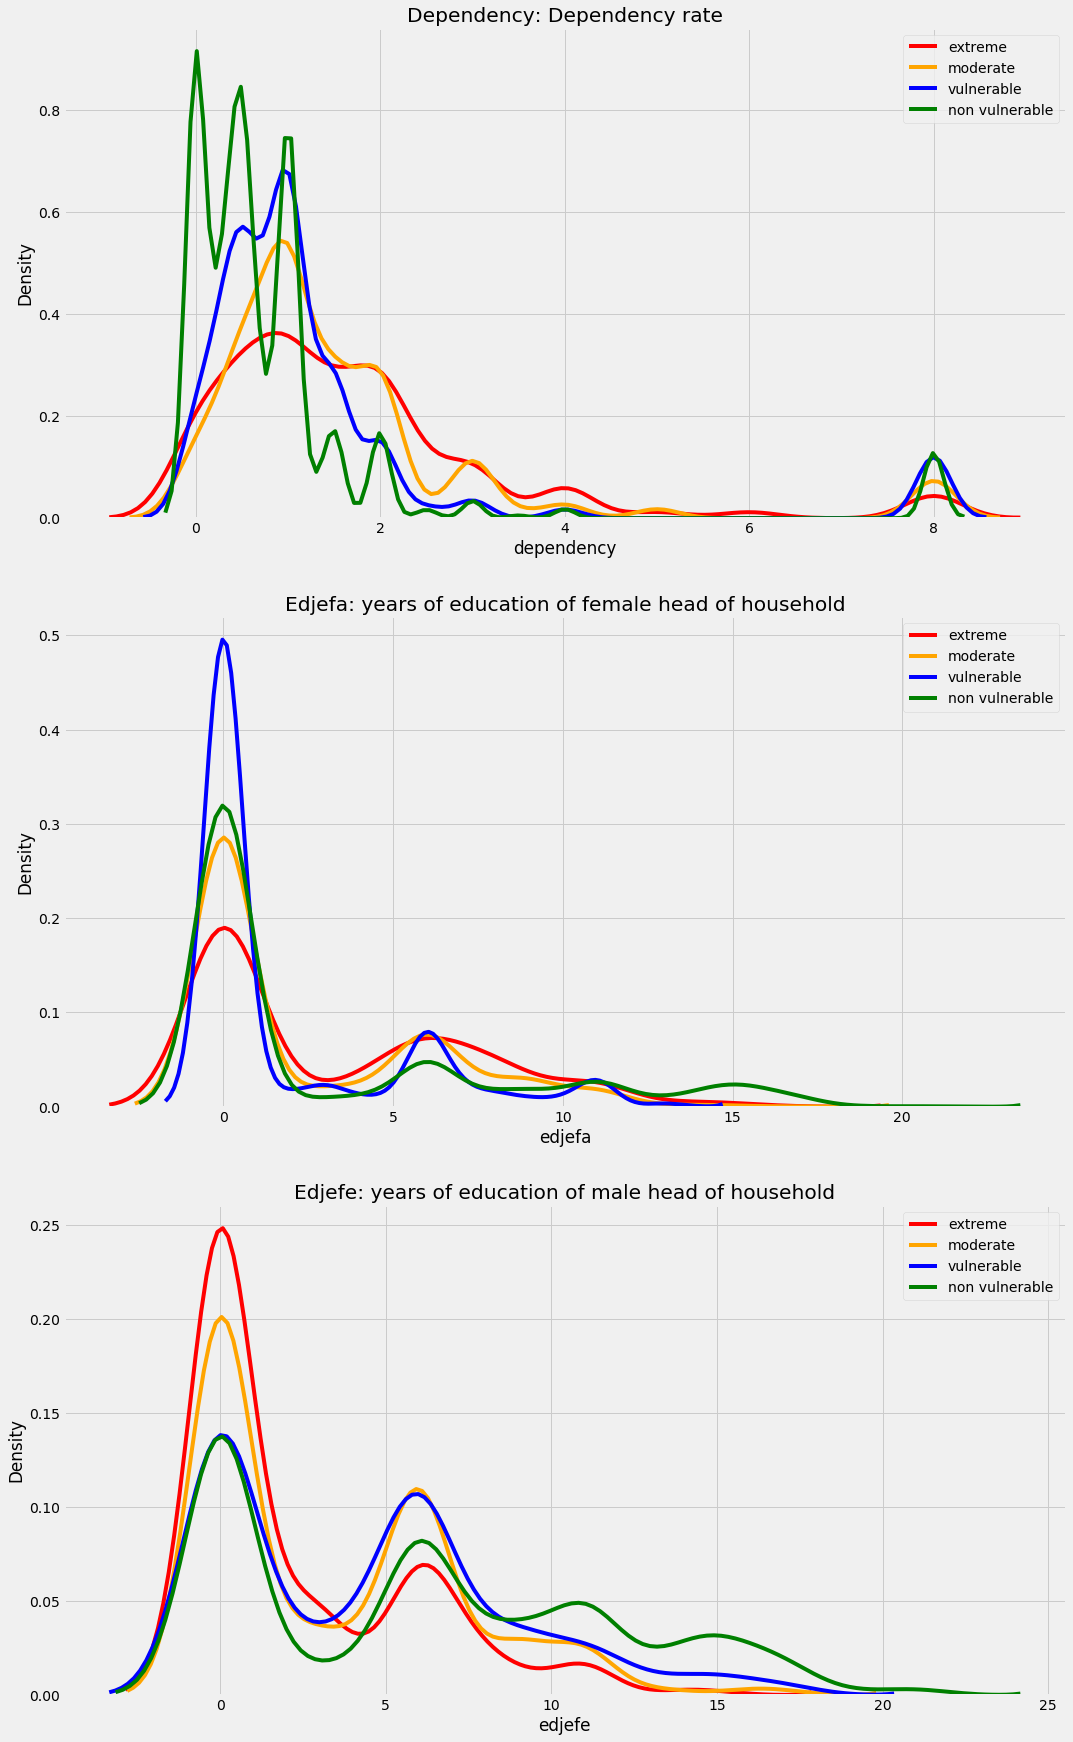

In [17]:
plt.figure(figsize = (16, 12))

# Iterate through the 3 columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    
    ### get the col desc
    col_desc = data_desc.loc[data_desc['Variable name'] == col]['Variable description'].values[0]
    
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna().values, 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()}: {col_desc}'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Lets see now what are the dtypes in our train set:

In [18]:
train.select_dtypes(['object']).columns

Index(['Id', 'idhogar'], dtype='object')

The only obj cols are `['Id', 'idhogar']` which is expected

---

```
To make operations like that above a little easier, we'll join together the training and testing dataframes. This is important once we start feature engineering because we want to apply the same operations to both dataframes so we end up with the same features. Later we can separate out the sets based on the `Target`.
```

In [19]:
# Add null Target column to test
test['Target'] = np.nan
print (train.shape, test.shape)
data = train.append(test, ignore_index = True)
print (data.shape)

data.head()

(9557, 143) (23856, 143)
(33413, 143)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,0.0,10.0,0.0,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8.0,12.0,0.0,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4.0
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8.0,0.0,11.0,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4.0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4.0


In [20]:
data.tail()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
33408,ID_a065a7cad,NaN,1,2,1,1,1,0,NaN,0,2,2,1,3,4,1,5,6,6,6,3,0.0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3aa78c56b,2,4,0,6,0.5,5.0,0.0,5.75,0,1,0,0,0,0,0,0,0,1,6.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,10,9,100,36,25,4,36.0,0.25,33.0625,100,NaN
33409,ID_1a7c6953b,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,6,NaN,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,0,1,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,54,36,2916,16,36,4,4.0,1.00,36.0000,2916,NaN
33410,ID_07dbb4be2,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,4,1.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,1,0,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,12,16,144,16,36,4,4.0,1.00,36.0000,144,NaN
33411,ID_34d2ed046,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,5,0.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,1,0,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,12,25,144,16,36,4,4.0,1.00,36.0000,144,NaN
33412,ID_34754556f,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,6,NaN,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,0,1,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,51,36,2601,16,36,4,4.0,1.00,36.0000,2601,NaN


In [21]:
test.tail()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
23851,ID_a065a7cad,NaN,1,2,1,1,1,0,NaN,0,2,2,1,3,4,1,5,6,6,6,3,0.0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3aa78c56b,2,4,0,6,0.5,5.0,0.0,5.75,0,1,0,0,0,0,0,0,0,1,6.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,10,9,100,36,25,4,36.0,0.25,33.0625,100,NaN
23852,ID_1a7c6953b,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,6,NaN,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,0,1,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,54,36,2916,16,36,4,4.0,1.00,36.0000,2916,NaN
23853,ID_07dbb4be2,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,4,1.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,1,0,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,12,16,144,16,36,4,4.0,1.00,36.0000,144,NaN
23854,ID_34d2ed046,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,5,0.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,1,0,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,12,25,144,16,36,4,4.0,1.00,36.0000,144,NaN
23855,ID_34754556f,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,6,NaN,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,0,1,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,51,36,2601,16,36,4,4.0,1.00,36.0000,2601,NaN


### Exploring Label Distribution

Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where `parentesco1 == 1` because this is the head of household, the correct label for each household.

The bar plot below shows the distribution of training labels (since there are no testing labels).

In [22]:
# heads of households
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training: where target is not null and the parentesco1 == 1 (for head of household)
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

print (train_labels['Target'].value_counts())

4.0    1954
2.0     442
3.0     355
1.0     222
Name: Target, dtype: int64


In [23]:
# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()
colors

OrderedDict([(1, 'red'), (2, 'orange'), (3, 'blue'), (4, 'green')])

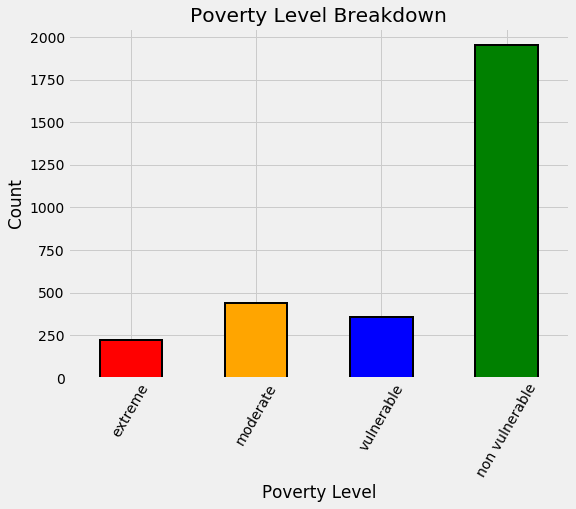

In [24]:
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

plt.xticks([x-1 for x in poverty_mapping.keys()], list(poverty_mapping.values()), rotation = 60)
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.title('Poverty Level Breakdown');

We are dealing with an imbalanced class problem (which makes it intriguing why the contest organizers choose the _macro_ F1 score as the metric instead of _weighted_ F1!). There are many more households that classify as _non vulnerable_ than in any other category. The _extreme_ poverty class is the smallest (I guess this should make us optimistic!).

One problem with imbalanced classification problems is that the machine learning model can have a difficult time predicting the minority classes because it sees far less examples. Think about this in human terms: if we are classifiying poverty and we see far more cases of no poverty than extreme poverty, it will make it more difficult for us to identify the high poverty households because of less exposure. One potential method to address class imbalanceds is through oversampling  (which is covered in more advanced notebooks).

### Addressing Wrong Labels

As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. These can be either human entry errors, measurement errors, or sometimes just extreme values that are correct but stand out. For this problem, some of the labels are not correct because _individuals in the same household have a different poverty level_. We're not told why this may be the case, but we are told to __use the head of household as the true label.__

That information makes our job much easier, but in a real-world problem, we would have to figure out the reason _Why_ the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.


### Identify Errors

First we need to find the errors before we can correct them. To find the households with different labels for  family members, we can group the data by the household and then check if there is only one unique value of the `Target`.

`idhogar` is the unique id for each household

In [28]:
aggregation = {
    'Target': 'nunique' ## get the number of unique Targets per household ID
}

num_unique_targets_per_household = train.groupby('idhogar').agg(aggregation)

num_unique_targets_per_household.head()

,Target
idhogar,
001ff74ca,1
003123ec2,1
004616164,1
004983866,1
005905417,1


In [29]:
### check where Target > 1

prob_households = num_unique_targets_per_household.loc[num_unique_targets_per_household['Target'] > 1]

print('There are {} households where the family members do not all have the same target.'.format(len(prob_households)))

There are 85 households where the family members do not all have the same target.


Lets look at one such household: We select the first index of the prob households and look at the parenscol1 (parentesco1, =1 if household head) and Target features

In [30]:
train.loc[train['idhogar'] == prob_households.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


The organizers tell us that the correct label is that for the head of household, where `parentesco1 == 1`. For this household, the correct label is __3__ for all members. We can correct this (as shown later) by reassigning all the individuals in this household the correct poverty level. In the real-world, you might have to make the tough decision of how to address the problem by yourself (or with the help of your team).

### Families without Heads of Household

We can correct all the label discrepancies by assigning the individuals in the same household the label of the head of household. But wait, you may ask: "What if there are households without a head of household? And what if the members of those households have differing values of the label?" 

Well, since you asked, let's investigate exactly that question! 

So basically each unique `idhogar` should have SUM(parentscol) == 1, lets check that first

In [36]:
aggregation = {
    'parentesco1': 'sum' ## get sum of parentscol1 for each household
}

train.groupby('idhogar').agg(aggregation)['parentesco1'].unique()

array([1, 0])

So there are some household where there are no rows with parentsco1 == 1, so they do not have heads of households. We have to investigate these rows

**The good news is that there are no households with multiple heads of households**

In [34]:
### find the number of households without a head

num_heads_per_household = train.groupby('idhogar').agg(aggregation)['parentesco1']

num_heads_per_household.head()

idhogar
001ff74ca    1
003123ec2    1
004616164    1
004983866    1
005905417    1
Name: parentesco1, dtype: int64

In [39]:
num_heads_per_household[num_heads_per_household<1]

idhogar
03c6bdf85    0
09b195e7a    0
1367ab31d    0
1bc617b23    0
374ca5a19    0
61c10e099    0
6b1b2405f    0
896fe6d3e    0
a0812ef17    0
ad687ad89    0
b1f4d89d7    0
bfd5067c2    0
c0c8a5013    0
d363d9183    0
f2bfa75c4    0
Name: parentesco1, dtype: int64

In [41]:
households_no_head = train.loc[train['idhogar'].isin(num_heads_per_household[num_heads_per_household==0].index), :]
print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [47]:
households_no_head

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
4935,ID_717302050,NaN,0,8,0,1,1,0,NaN,0,2,2,0,2,2,0,4,4,4,4,6,NaN,4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,09b195e7a,2,2,0,4,1.000000,6.0,0.0,6.000000,0,0,1,0,0,0,0,0,0,5,0.800000,1,0,0,0,0,0,1,1,4,1,0,0,0,0,0,0,1,34,36,1156,16,36,4,0.640000,1.000000,36.000000,1156,3
4975,ID_ff6f13458,NaN,0,4,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,9,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,896fe6d3e,2,2,0,4,1.000000,9.0,0.0,7.500000,0,0,0,0,0,1,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,16,81,256,16,81,4,4.000000,1.000000,56.250000,256,3
5391,ID_64c9eabac,NaN,0,5,0,1,1,0,NaN,0,1,1,0,2,2,0,3,3,3,3,14,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,61c10e099,0,3,0,3,0.000000,6.0,0.0,8.666667,0,0,0,0,0,0,0,1,0,3,1.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,20,196,400,9,36,0,1.000000,0.000000,75.111115,400,3
5396,ID_8948b1f91,90000.0,0,5,0,1,1,0,NaN,2,1,3,1,1,2,3,2,5,5,5,3,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,374ca5a19,3,2,0,5,1.500000,6.0,0.0,8.500000,0,1,0,0,0,0,0,0,0,3,1.666667,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,0,1,10,9,100,25,36,9,2.777778,2.250000,72.250000,100,3
6443,ID_8ddb34d2c,NaN,0,3,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,0,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.000000,3.0,0.0,6.000000,1,0,0,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,7,0,49,16,9,4,4.000000,1.000000,36.000000,49,3
6444,ID_03e2f23b0,NaN,0,3,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,6,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.000000,3.0,0.0,6.000000,0,0,1,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,13,36,169,16,9,4,4.000000,1.000000,36.000000,169,3
7086,ID_ba2ac56bb,NaN,0,4,0,1,1,0,NaN,0,1,1,2,2,4,2,3,5,5,5,11,NaN,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1367ab31d,3,2,0,5,1.500000,16.0,0.0,18.000000,0,0,0,0,1,0,0,0,0,2,2.500000,1,0,0,0,0,0,0,1,3,0,0,1,0,0,0,0,1,19,121,361,25,256,9,6.250000,2.250000,324.000000,361,3
7438,ID_7ba374a80,NaN

So these are the rows where we do not have a head of household, i.e when we group by `idhogar`, there is not a single row with `parentsco1 == 1`

Now, previously we decided that on the rows of the same household with multiple Targets, we will take the row with the household head as the correct one.

What if that household has no head?

In [45]:
households_no_head.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
4935,ID_717302050,NaN,0,8,0,1,1,0,NaN,0,2,2,0,2,2,0,4,4,4,4,6,NaN,4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,09b195e7a,2,2,0,4,1.0,6.0,0.0,6.000000,0,0,1,0,0,0,0,0,0,5,0.800000,1,0,0,0,0,0,1,1,4,1,0,0,0,0,0,0,1,34,36,1156,16,36,4,0.640000,1.00,36.000000,1156,3
4975,ID_ff6f13458,NaN,0,4,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,9,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,896fe6d3e,2,2,0,4,1.0,9.0,0.0,7.500000,0,0,0,0,0,1,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,16,81,256,16,81,4,4.000000,1.00,56.250000,256,3
5391,ID_64c9eabac,NaN,0,5,0,1,1,0,NaN,0,1,1,0,2,2,0,3,3,3,3,14,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,61c10e099,0,3,0,3,0.0,6.0,0.0,8.666667,0,0,0,0,0,0,0,1,0,3,1.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,20,196,400,9,36,0,1.000000,0.00,75.111115,400,3
5396,ID_8948b1f91,90000.0,0,5,0,1,1,0,NaN,2,1,3,1,1,2,3,2,5,5,5,3,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,374ca5a19,3,2,0,5,1.5,6.0,0.0,8.500000,0,1,0,0,0,0,0,0,0,3,1.666667,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,0,1,10,9,100,25,36,9,2.777778,2.25,72.250000,100,3
6443,ID_8ddb34d2c,NaN,0,3,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,0,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.0,3.0,0.0,6.000000,1,0,0,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,7,0,49,16,9,4,4.000000,1.00,36.000000,49,3


In [48]:
households_no_head.groupby('idhogar').agg({'Target': 'nunique'})

,Target
idhogar,
03c6bdf85,1
09b195e7a,1
1367ab31d,1
1bc617b23,1
374ca5a19,1
61c10e099,1
6b1b2405f,1
896fe6d3e,1
a0812ef17,1


Well that's a relief! This means that we don't have to worry about a household both where there is no head __AND__ the members have different values of the label! For this problem, according to the organizers, __if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training__ Nonetheless, it's still a good exercise to go through this process of investigating the data! 

### Correct Errors

Now we can correct labels for the households that do have a head __AND__ the members have different poverty levels.